In [26]:
import run_simulation as rs
import numpy as np	
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tdgl
import os 
rs.check_system()

GPU is available
GPU:  b'NVIDIA GeForce RTX 4060 Laptop GPU'


In [27]:
xi=0.1
size=1.0

min_c=0
max_c=20
num_c=100
H_field_range=np.round(np.linspace(0,25,10),3)
current_range=np.round(np.linspace(min_c,max_c,num_c), 3)
device=rs.define_4_terminal_mesh(size,size,xi=xi, probes=[((-size*(0.4),0),
					   				(size*(0.4),0),)],
									terminal_width=size/30,
									terminal_height=size/10
									)


In [28]:
folder_path = 'H_fields_4'
files = rs.get_all_files(folder_path)

data_list=[]

for file in files:
	H_field, current = rs.extract_numbers(file)
	array=np.load(file)
	data=[H_field,current,array]
	data_list.append(data)
	

In [29]:
H_fields_list=[]
currents_for_H=[]
currents=[]


for data in data_list:
	if data[0] not in H_fields_list:
		H_fields_list.append(data[0])
		currents_for_H.append(currents)
		currents=[data[1]]
	else:
		index=H_fields_list.index(data[0])
		currents.append(data[1])
		
currents_for_H.append(currents)
currents_for_H=currents_for_H[1:]
	

found_Hs,missing_Hs=rs.check_elements_in_list(H_field_range,H_fields_list)

print(f"found data for H= {found_Hs}")
print(f"missing data for H= {missing_Hs}")

simulations_to_be_computed={}

for ii in range(len(found_Hs)):
	found_C,missing_C=rs.check_elements_in_list(current_range,currents_for_H[ii])

	simulations_to_be_computed[found_Hs[ii]]=np.array(missing_C)

for ii in range(len(missing_Hs)):

	simulations_to_be_computed[missing_Hs[ii]]=current_range

for key, value in simulations_to_be_computed.items():
    print(f"{key}: {value}")

found data for H= [0.0, 2.778, 5.556, 8.333, 11.111, 13.889, 16.667, 19.444, 22.222]
missing data for H= [25.0]
0.0: []
2.778: []
5.556: []
8.333: []
11.111: []
13.889: []
16.667: []
19.444: []
22.222: []
25.0: [ 0.     0.202  0.404  0.606  0.808  1.01   1.212  1.414  1.616  1.818
  2.02   2.222  2.424  2.626  2.828  3.03   3.232  3.434  3.636  3.838
  4.04   4.242  4.444  4.646  4.848  5.051  5.253  5.455  5.657  5.859
  6.061  6.263  6.465  6.667  6.869  7.071  7.273  7.475  7.677  7.879
  8.081  8.283  8.485  8.687  8.889  9.091  9.293  9.495  9.697  9.899
 10.101 10.303 10.505 10.707 10.909 11.111 11.313 11.515 11.717 11.919
 12.121 12.323 12.525 12.727 12.929 13.131 13.333 13.535 13.737 13.939
 14.141 14.343 14.545 14.747 14.949 15.152 15.354 15.556 15.758 15.96
 16.162 16.364 16.566 16.768 16.97  17.172 17.374 17.576 17.778 17.98
 18.182 18.384 18.586 18.788 18.99  19.192 19.394 19.596 19.798 20.   ]


In [ ]:
rs.build_mesh(device,max_edge_L=xi/4,plot=False)

In [ ]:
for H in simulations_to_be_computed:
	currents=simulations_to_be_computed[H]
	if currents.size == 0:
		continue
	else:
		print(f"simulating H={H}, \nc={currents}------------------------------------")
		solutions,currents=rs.current_series(device,
						current_range=currents,
						H_field=H,
						solve_time=300
						)
		jj=0
		for solution in solutions:
			voltage=solution.dynamics.voltage()
			time=solution.dynamics.time
			solution.to_hdf5(f'H_solutions/solution_{H}_{currents[jj]}_.hdf5')

			np.save(f'{folder_path}/voltages_{H}_{currents[jj]}_.npy',np.array((time,voltage)))
			jj+=1


In [11]:



folder_path = 'H_fields_4'
files = rs.get_all_files(folder_path)

data_list=[]
max_H=0
for file in files:
	H_field, current = rs.extract_numbers(file)
	array=np.load(file)
	data=[H_field,current,array]
	if H_field>max_H:
		max_H=H_field
	data_list.append(data)



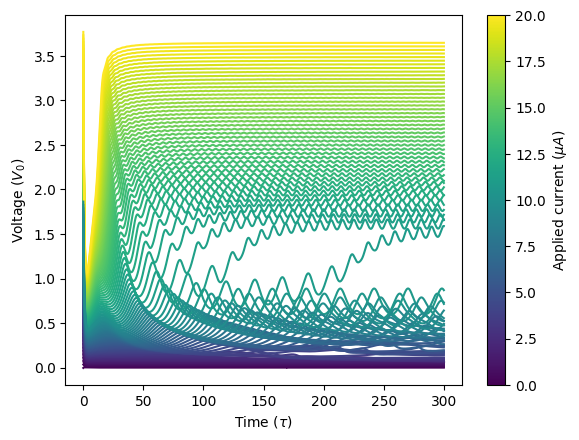

In [25]:
# for H in H_field_range:
voltages=[]
currents=[]


fig,ax=plt.subplots()

for data in data_list:
	if data[0]==H_field_range[3]:
		ax.plot(data[2][0],data[2][1],label=f'H={data[0]}, c={data[1]}',c=cm.viridis(data[1]/np.max(current_range)))

ax.set_xlabel('Time ($\\tau$)')
ax.set_ylabel('Voltage ($V_0$)')
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(current_range), vmax=max(current_range)))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Applied current ($\mu A$)')

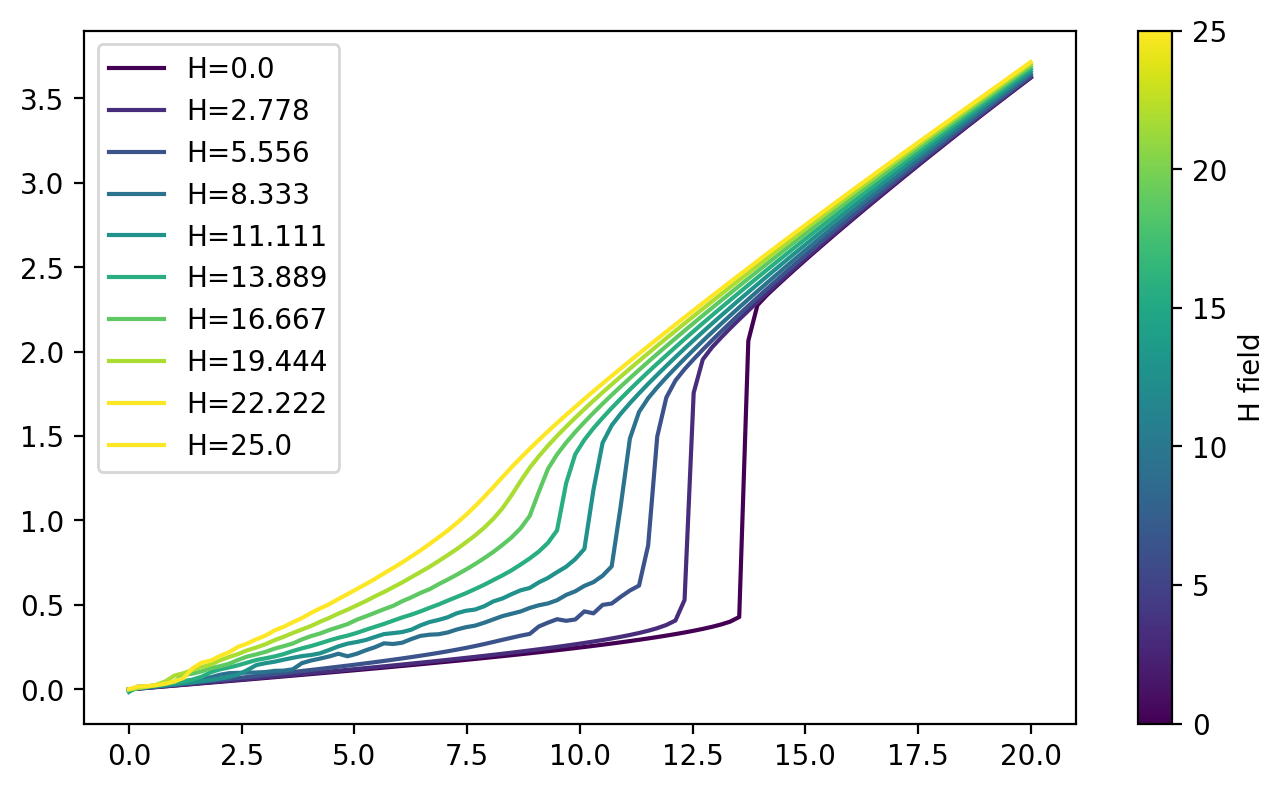

In [62]:
def sort_and_pair(x, y):

    paired = list(zip(x, y))
    paired_sorted = sorted(paired, key=lambda pair: pair[0])
    x_sorted, y_sorted = zip(*paired_sorted)
    x_sorted = list(x_sorted)
    y_sorted = list(y_sorted)

    return x_sorted, y_sorted

fig, ax = plt.subplots(figsize=(16/2, 9/2),dpi=200)

H_data=[]
currents_data=[]
voltages_data=[]
for H in H_field_range:
	voltages=[]
	currents=[]
	for data in data_list:
		if data[0]==H:
			# plt.plot(data[2][0],data[2][1],label=f'H={data[0]}, c={data[1]}',c=cm.viridis(data[1]/20))
			voltages.append(np.mean(data[2][1,-int(0.5*len(data[2][1])):]))
			currents.append(data[1])
	try:
		currents,voltages=sort_and_pair(currents,voltages)	
		currents_data.append(currents)
		voltages_data.append(voltages)
		H_data.append(H)
	except:
		pass

	ax.plot(currents,voltages,label=f'H={H}',c=cm.viridis(H/max_H))

    # ax.plot(currents, voltages, label=f'H={H}', c=cm.viridis(H / max_H))

sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(H_field_range), vmax=max(H_field_range)))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='H field')

ax.legend()
plt.show()	

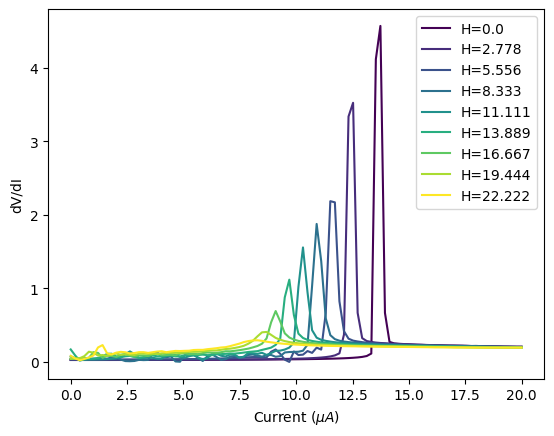

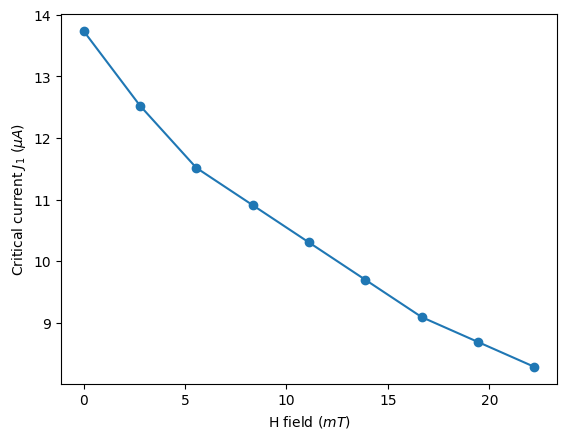

In [41]:
j1=np.zeros(len(H_data))
for ii in range(len(H_data)):
	dv_dA=np.gradient(voltages_data[ii],currents_data[ii])
	j1[ii]=currents_data[ii][np.argmax(dv_dA)]
	plt.plot(currents_data[ii],dv_dA,label=f'H={H_data[ii]}',c=cm.viridis(H_data[ii]/max(H_data)))
plt.xlabel('Current ($\mu A$)')
plt.ylabel('dV/dI')
plt.legend()
plt.show()
plt.clf()
plt.close()
plt.scatter(H_data,j1)
plt.plot(H_data,j1)
plt.xlabel('H field ($mT$)')
plt.ylabel('Critical current $J_1$ ($\mu A$)')

plt.show()	